In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import pickle

import random

from openpyxl import load_workbook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap



pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")
%matplotlib inline


### 📊 *Sprints 3 - 4*  

- Foi concluída a **calibração dos hiperparâmetros** do modelo `RandomForestRegressor`.  
  - O ajuste reduziu de forma consistente o erro (MAE ≈ **1.26** e RMSE ≈ **1.87** no teste) e aumentou o **R²** para **~0.70** tanto em treino quanto em teste.  
  - Esse equilíbrio mostra que **o modelo não apresenta overfitting relevante**, já que o desempenho é estável nos dois cenários.  

- A **validação cruzada (CV)** confirmou a robustez do modelo, com média de **R² ≈ 0.695** e **desvio-padrão baixo (~0.015)**, evidenciando **boa estabilidade e consistência** nas diferentes divisões de dados.  

- Foi realizada a análise de **importância das variáveis**:  
  - A feature **`produtividade_estimada`** foi disparadamente a mais relevante (**~0.93** de contribuição segundo SHAP), indicando que o modelo se apoia fortemente nela para prever a duração da sprint.  
  - Outras variáveis, como **`qtd_bugs`**, **`velocidade_passada`**, **`complexidade_total`** e **`carga_cartoes_por_membro`**, apresentaram **impacto marginal** (importância < 0.01).  
  - Isso sugere que é possível adotar uma **estratégia de redução de dimensionalidade**, priorizando atributos realmente relevantes, o que simplifica o modelo e reduz custos computacionais sem perda significativa de desempenho.  

- A análise com **SHAP** também permitiu interpretar as predições individualmente, facilitando a compreensão de **quais fatores impulsionam aumentos ou reduções na estimativa de duração** para cada sprint. Esse tipo de explicação pode ser útil para **gestores de projeto** na tomada de decisão.  




### 📋 Resultados do Modelo - Random Forest Regressor

| Métrica        | Treino  | Teste  | CV (média) | CV (std) |
|----------------|---------|--------|------------|----------|
| **MAE**        | 1.16    | 1.26   | -          | -        |
| **RMSE**       | 1.73    | 1.87   | -          | -        |
| **R²**         | 0.748   | 0.703  | 0.695      | 0.015    |

✅ Observações:
- O **R² em treino e teste** estão próximos, sugerindo **boa generalização**.  
- O **CV (Cross-Validation)** confirma a estabilidade do modelo, com desvio-padrão muito baixo (~0.015).  
- O **MAE** (erro médio absoluto) está em torno de **1 dia**, o que indica **boa precisão prática** para o problema de previsão de duração de sprints.  


---

### ✅ Conclusão  

- O modelo apresenta uma **evolução animadora**, mostrando **boa generalização** mesmo em dados sintéticos.  
- Os resultados reforçam o potencial de uso em **cenários reais de produção**, especialmente para apoiar **estimativas de sprints** no planejamento ágil.  
- Futuramente, pode ser melhorado com:  
  - Inclusão de **novas features contextuais** (ex.: composição da equipe, histórico de retrabalho, variabilidade na produtividade).  
  - Estratégias de **feature selection automatizada** para balancear relevância e interpretabilidade.  


In [15]:
df = pd.read_csv("../datasets/data_prepared_2.csv")
df.head()

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada
0,5,20,23,1.603110,1,2.5,0.20,0.05,32.57,2.202321
1,6,14,49,-0.650644,1,2.4,0.05,0.13,45.12,-1.258732
2,7,20,49,0.437375,1,2.9,0.12,0.18,69.79,-0.460027
3,6,13,31,-0.161035,0,3.7,0.10,0.10,47.70,-0.699639
4,5,15,48,-0.242637,1,2.1,0.17,0.12,42.69,-0.326910


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   qtd_membros             5000 non-null   int64  
 1   duracao_dias            5000 non-null   int64  
 2   cartoes_previstos       5000 non-null   int64  
 3   story_points_previstos  5000 non-null   float64
 4   tipo_dominio            5000 non-null   int64  
 5   complexidade_media      5000 non-null   float64
 6   percentual_bugs         5000 non-null   float64
 7   percentual_retrabalho   5000 non-null   float64
 8   velocidade_passada      5000 non-null   float64
 9   produtividade_estimada  5000 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 390.8 KB


#### Testando novas features

In [ ]:

### craindo novas features

# 1. Bugs e retrabalho estimados
df["qtd_bugs"] = df["percentual_bugs"] * df["cartoes_previstos"]

df["qtd_retrabalho"] = df["percentual_retrabalho"] * df["cartoes_previstos"]

# 2. Carga por membro
df["carga_cartoes_por_membro"] = df["cartoes_previstos"] / df["qtd_membros"]
# df["carga_storypoints_por_membro"] = df["story_points_previstos"] / df["qtd_membros"]

# 3. Eficiência (velocidade normalizada)
# df["eficiencia"] = df["velocidade_passada"] / df["cartoes_previstos"]

# 4. Complexidade total
# df["complexidade_total"] = df["complexidade_media"] * df["cartoes_previstos"]

# 5. Produtividade gap
#df["produtividade_gap"] = (df["velocidade_passada"] / df["qtd_membros"]) - df["produtividade_estimada"]




In [5]:
df.head()

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada,qtd_bugs,qtd_retrabalho,carga_cartoes_por_membro,carga_storypoints_por_membro,eficiencia,complexidade_total,produtividade_gap
0,5,20,23,1.603110,1,2.5,0.20,0.05,32.57,2.202321,4.60,1.15,4.600000,0.320622,1.416087,57.5,4.311679
1,6,14,49,-0.650644,1,2.4,0.05,0.13,45.12,-1.258732,2.45,6.37,8.166667,-0.108441,0.920816,117.6,8.778732
2,7,20,49,0.437375,1,2.9,0.12,0.18,69.79,-0.460027,5.88,8.82,7.000000,0.062482,1.424286,142.1,10.430027
3,6,13,31,-0.161035,0,3.7,0.10,0.10,47.70,-0.699639,3.10,3.10,5.166667,-0.026839,1.538710,114.7,8.649639
4,5,15,48,-0.242637,1,2.1,0.17,0.12,42.69,-0.326910,8.16,5.76,9.600000,-0.048527,0.889375,100.8,8.864910


In [7]:
df.columns # Produtividade_estimada, complexidade_media, qtd_retrabalho, qtd_bugs, carga_cartoes_por_membro, 

df = df[['duracao_dias', 'produtividade_estimada',
       'tipo_dominio', 'complexidade_media',
       'qtd_bugs', 'qtd_retrabalho',
       'carga_cartoes_por_membro']]

##### Split dos dados em treino e teste (Random Forest)

In [11]:

X = df.drop(columns=["duracao_dias"])
y = df["duracao_dias"]

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# max_depth=8, min_samples_leaf=5, max_features=25, ccp_alpha=0.0005, n_estimators=1300 , criterion="friedman_mse", max_samples=0.8604699621260646, random_state=1,

# --- Criar modelo Random Forest ---
rf = RandomForestRegressor(
    n_estimators=1300,
    max_depth=8,
    max_samples=0.8604699621260646,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=25,
    random_state=1,
    ccp_alpha=0.0005,
    bootstrap=True,
    n_jobs=-1,
    criterion="friedman_mse"
)

# --- Treinar ---
rf.fit(X_train, y_train)

# --- Previsões ---
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# --- Métricas ---
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("=== Desempenho Random Forest ===")
print(f"MAE Treino: {mae_train:.2f}, Teste: {mae_test:.2f}")
print(f"RMSE Treino: {rmse_train:.2f}, Teste: {rmse_test:.2f}")
print(f"R² Treino: {r2_train:.3f}, Teste: {r2_test:.3f}")

=== Desempenho Random Forest ===
MAE Treino: 1.14, Teste: 1.23
RMSE Treino: 1.75, Teste: 1.85
R² Treino: 0.743, Teste: 0.708


#### Salvando o modelo RF

In [12]:
model_name = "../model/agile_estimator.pkl"

with open(model_name, 'wb') as file:
    pickle.dump(rf, file)


🔹 Gráfico de Valores Reais vs Preditos

    A linha preta tracejada é a ideal (y = x, previsão perfeita).

    Os pontos seguem uma tendência crescente, mas com dispersão vertical grande:

    Alguns sprints de 20 dias foram previstos entre 16 e 20.

    Alguns sprints curtos (12–14 dias) foram previstos mais alto do que deveriam.

    Isso mostra que o modelo acerta a direção (mais tarefas = mais dias), mas não consegue prever com precisão exata.





🔹 O que são resíduos?

    Resíduo = Valor Real − Valor Predito

    Se o resíduo é positivo → o modelo subestimou (previu menos dias do que realmente foi).

    Se o resíduo é negativo → o modelo superestimou (previu mais dias do que realmente foi).

    Idealmente: resíduos devem estar distribuídos de forma aleatória em torno de 0, sem padrão.

🔹 Relação com os resíduos

    Quando o R² é alto, os resíduos tendem a ser pequenos e concentrados perto de 0.

    Quando o R² é baixo, os resíduos ficam mais espalhados, indicando que o modelo não conseguiu captar muito da estrutura dos dados.

    O  gráfico de resíduos confirma isso: eles ainda são bem espalhados (até ±6 dias).

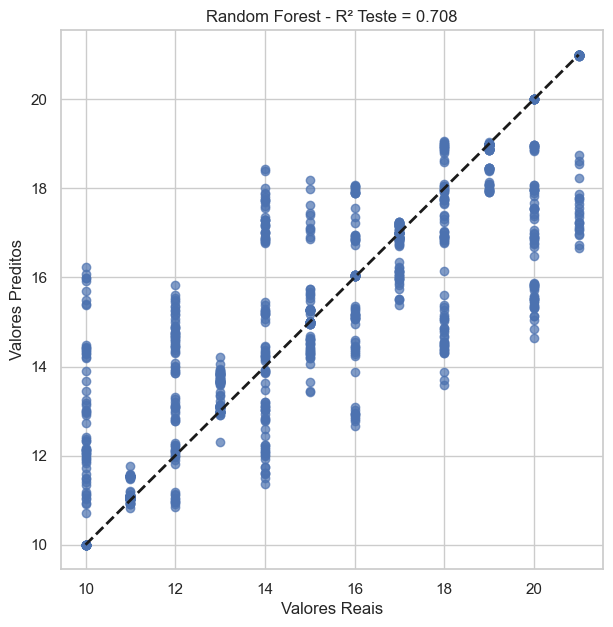

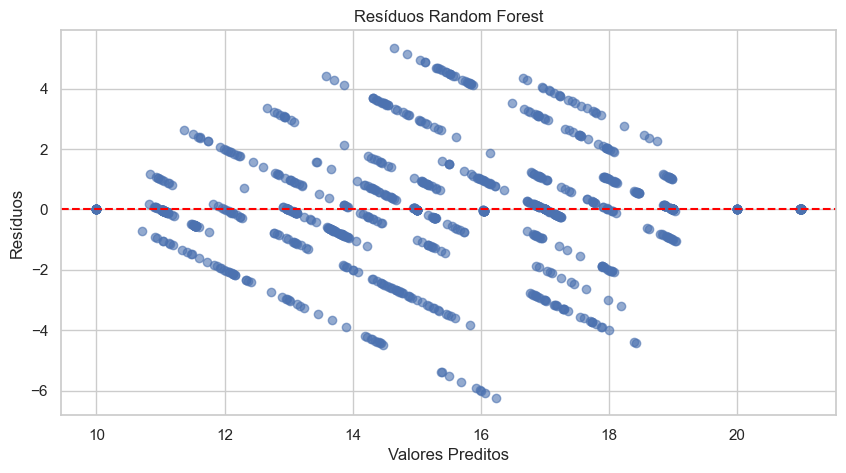

In [10]:
# --- Gráfico: valores reais vs preditos ---
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"Random Forest - R² Teste = {r2_test:.3f}")
plt.show()

# --- Gráfico: resíduos ---
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos Random Forest")
plt.show()

### 📌 Análise do Random Forest com Cross_Val_Score

**1. Desempenho do modelo**
- MAE Treino ≈ 1.16, Teste ≈ 1.26  
- RMSE Treino ≈ 1.73, Teste ≈ 1.87  
- R² Treino ≈ 0.748, Teste ≈ 0.703  
- Diferenças pequenas entre treino e teste → **baixo overfitting** e boa generalização.

**2. Validação cruzada**
- R² médio (CV=5): **0.694 ± 0.015**  
- Confirma que o modelo é **estável** e não depende de apenas um split de dados.

**3. Importância de Features (Random Forest)**
- `produtividade_estimada` domina com ~92% da importância.  
- Outras variáveis (`qtd_bugs`, `velocidade_passada`, `complexidade_total`, etc.) aparecem com importâncias muito menores (<1%).  
- Isso sugere que o modelo se apoia fortemente em uma única variável para prever `duracao_dias`.

In [16]:
scores = cross_val_score(rf, X, y, cv=5, scoring="r2", n_jobs=-1)
print("R² CV mean:", scores.mean(), "std:", scores.std())


fi = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)
print(fi.head(10))


R² CV mean: 0.6945283882377037 std: 0.015134549261555703
                     Feature  Importance
8     produtividade_estimada    0.928529
9                   qtd_bugs    0.007637
7         velocidade_passada    0.006978
14        complexidade_total    0.006596
4         complexidade_media    0.006502
10            qtd_retrabalho    0.006452
11  carga_cartoes_por_membro    0.006195
15         produtividade_gap    0.006093
13                eficiencia    0.005575
5            percentual_bugs    0.004551


### 1) SHAP Summary Plot (Impacto Global)
O gráfico de resumo apresenta a importância global das variáveis no modelo.  
Constata-se que `produtividade_estimada` é a feature de maior impacto, seguida por `complexidade_media` e `complexidade_total`.  
Por outro lado, variáveis como `qtd_membros` e `carga_storypoints_por_membro` mostraram impacto mínimo, sugerindo baixa relevância para as previsões.

---

### 2) SHAP Dependence Plot (Produtividade Estimada)
A análise de dependência indica que valores elevados de `produtividade_estimada` exercem influência positiva na saída do modelo, enquanto valores reduzidos impactam negativamente.  
Adicionalmente, observa-se interação com `carga_cartoes_por_membro`: quando a carga é elevada, o efeito positivo da produtividade tende a ser atenuado.

---

### 3) SHAP Waterfall Plot (Exemplo Individual)
O gráfico waterfall detalha a decomposição de uma previsão específica.  
Neste caso, a variável `produtividade_estimada` contribuiu majoritariamente de forma negativa (–4.33), reduzindo a previsão final.  
Variáveis como `produtividade_gap` e `complexidade_total` exerceram contribuição positiva, ainda que de menor magnitude.  
Essa análise possibilita compreender a decisão do modelo em nível individual e fornecer justificativas claras para cada predição.


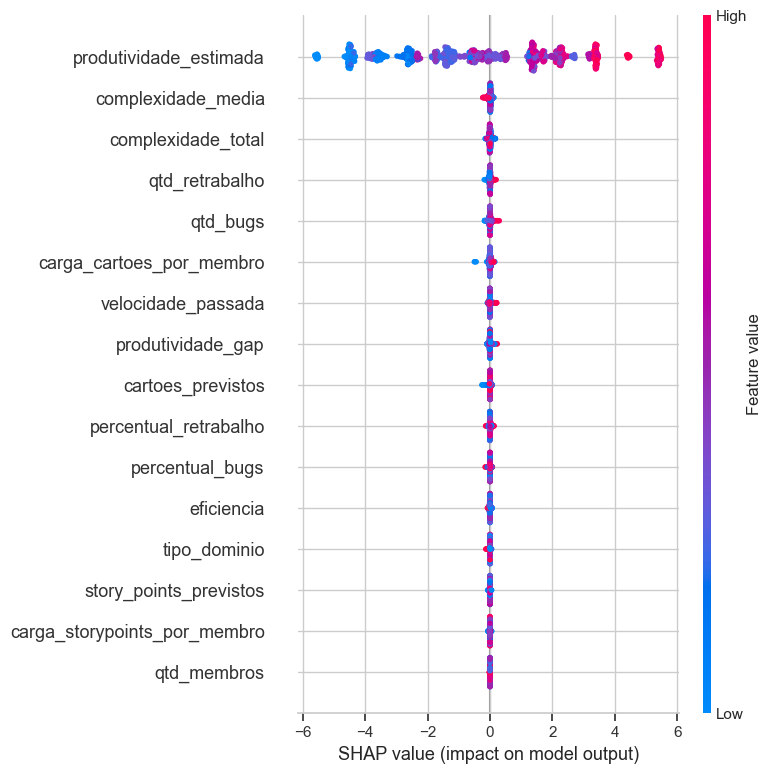

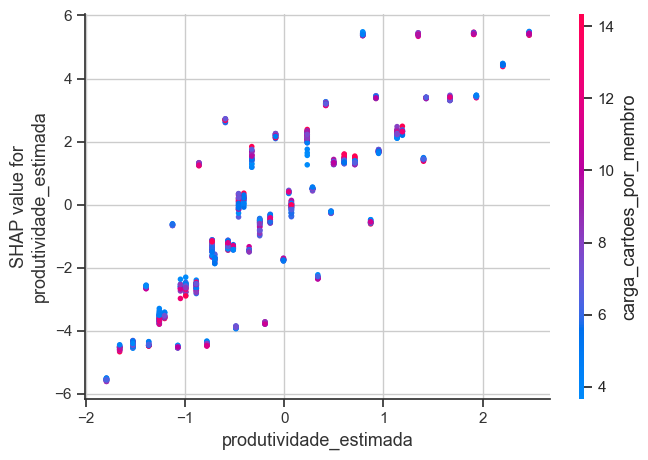

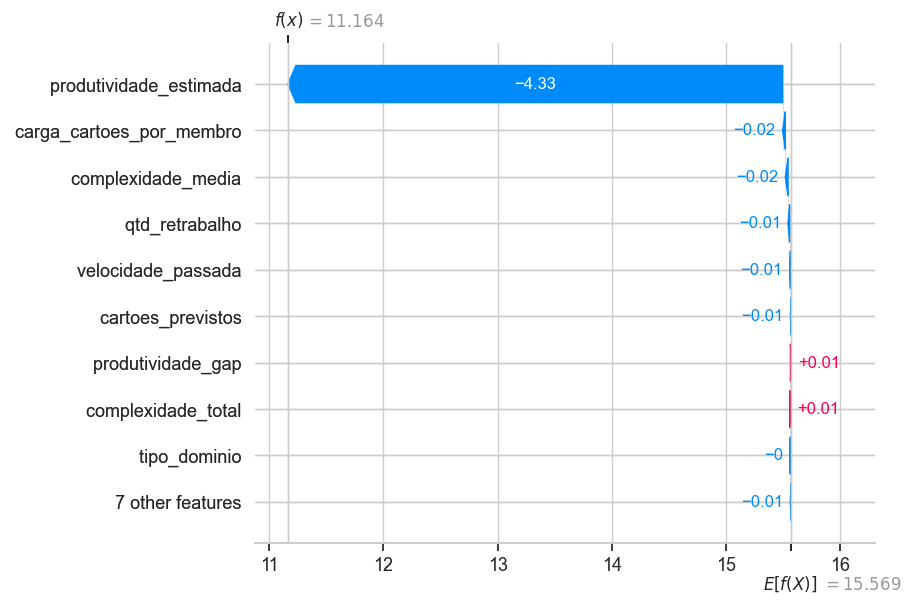

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 1) Resumo geral (impacto global)
shap.summary_plot(shap_values, X_test)

# 2) Dependência de produtividade_estimada
shap.dependence_plot("produtividade_estimada", shap_values, X_test)

# 3) Exemplo individual (primeira predição do teste)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[0],
    X_test.iloc[0]
)


#### Testando multiplas combinações de hiper parametros

In [ ]:

# --- Espaço de hiperparâmetros ---
param_grid = {
    "max_depth": [7, 8],
    "min_samples_leaf": [4, 5, 6],
    "max_features": [20, 25, 30],
    "ccp_alpha": [0.0005, 0.0009],
    "n_estimators": [1200, 1300]
}

# Criar todas as combinações possíveis
from itertools import product
combinations = list(product(
    param_grid["max_depth"],
    param_grid["min_samples_leaf"],
    param_grid["max_features"],
    param_grid["ccp_alpha"],
    param_grid["n_estimators"]
))

# Limitar a 50 combinações aleatórias se houver mais
if len(combinations) > 50:
    random.seed(1)
    combinations = random.sample(combinations, 50)

# Criar DataFrame para guardar resultados
results = pd.DataFrame(combinations, columns=[
    "max_depth", "min_samples_leaf", "max_features", "ccp_alpha", "n_estimators"
])
results["MAE_train"] = np.nan
results["MAE_test"] = np.nan
results["RMSE_train"] = np.nan
results["RMSE_test"] = np.nan
results["R2_train"] = np.nan
results["R2_test"] = np.nan

# --- Treinar e salvar resultados ---
for idx, row in results.iterrows():
    rf = RandomForestRegressor(
        n_estimators=int(row["n_estimators"]),
        max_depth=int(row["max_depth"]),
        min_samples_leaf=int(row["min_samples_leaf"]),
        max_features=int(row["max_features"]),
        bootstrap=True,
        max_samples=0.8604699621260646,    
        ccp_alpha=float(row["ccp_alpha"]),
        random_state=1,
        n_jobs=-1,
        criterion="friedman_mse"
    )
    
    rf.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    
    # Métricas
    results.loc[idx, "MAE_train"] = mean_absolute_error(y_train, y_pred_train)
    results.loc[idx, "MAE_test"] = mean_absolute_error(y_test, y_pred_test)
    results.loc[idx, "RMSE_train"] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    results.loc[idx, "RMSE_test"] = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results.loc[idx, "R2_train"] = r2_score(y_train, y_pred_train)
    results.loc[idx, "R2_test"] = r2_score(y_test, y_pred_test)

# Salvar resultados em CSV
results.to_csv("rf_hyperparam_results.csv", index=False)

print("Treinamento concluído! Resultados salvos em 'rf_hyperparam_results.csv'.")

display(results)


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


KeyboardInterrupt: 

#### Melhores hiper parametros eoncontrados com base no R2 e MAE

### Top 5 Hyperparameter Combinations based on MAE_test

| Index | max_depth | min_samples_leaf | max_features | ccp_alpha | n_estimators | MAE_train | MAE_test | RMSE_train | RMSE_test | R2_train | R2_test |
|-------|-----------|------------------|--------------|-----------|--------------|-----------|----------|------------|-----------|----------|---------|
| 47    | 8         | 5                | 25           | 0.0009    | 1300         | 1.164844  | 1.257680 | 1.742833   | 1.869130  | 0.745034 | 0.702917 |
| 33    | 8         | 5                | 30           | 0.0009    | 1300         | 1.164844  | 1.257680 | 1.742833   | 1.869130  | 0.745034 | 0.702917 |
| 4     | 8         | 6                | 20           | 0.0009    | 1300         | 1.167549  | 1.257688 | 1.747427   | 1.869891  | 0.743688 | 0.702676 |
| 22    | 8         | 6                | 30           | 0.0009    | 1300         | 1.167549  | 1.257688 | 1.747427   | 1.869891  | 0.743688 | 0.702676 |
| 39    | 8         | 5                | 20           | 0.0009    | 1200         | 1.164634  | 1.257697 | 1.742452   | 1.869348  | 0.745145 | 0.702848 |

### Top 5 Hyperparameter Combinations based on R2_test

| Index | max_depth | min_samples_leaf | max_features | ccp_alpha | n_estimators | MAE_train | MAE_test | RMSE_train | RMSE_test | R2_train | R2_test |
|-------|-----------|------------------|--------------|-----------|--------------|-----------|----------|------------|-----------|----------|---------|
| 47    | 8         | 5                | 25           | 0.0009    | 1300         | 1.164844  | 1.257680 | 1.742833   | 1.869130  | 0.745034 | 0.702917 |
| 33    | 8         | 5                | 30           | 0.0009    | 1300         | 1.164844  | 1.257680 | 1.742833   | 1.869130  | 0.745034 | 0.702917 |
| 13    | 8         | 5                | 25           | 0.0005    | 1300         | 1.164448  | 1.257734 | 1.742645   | 1.869148  | 0.745089 | 0.702912 |
| 18    | 8         | 5                | 20           | 0.0005    | 1300         | 1.164448  | 1.257734 | 1.742645   | 1.869148  | 0.745089 | 0.702912 |
| 5     | 8         | 5                | 30           | 0.0005    | 1300         | 1.164448  | 1.257734 | 1.742645   | 1.869148  | 0.745089 | 0.702912 |


#### Os resultados tem uma diferença irrisoria, porem um pouco melhores que no primeiro exemplo de código do nosso notebook, assim podemos escolher a combinação de hiper parametros com o menor MAE e maior R2




